In [1]:

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

# Set matplotlib to display in notebook
%matplotlib inline

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")



Using device: cuda


In [2]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same'),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Encoder
        self.conv1 = DoubleConv(1, 32)
        self.conv2 = DoubleConv(32, 64)
        self.conv3 = DoubleConv(64, 128)
        
        # Decoder
        self.up_conv2 = DoubleConv(192, 64)  # 128 + 64 channels
        self.up_conv1 = DoubleConv(96, 32)   # 64 + 32 channels
        
        # Final convolution
        self.final_conv = nn.Conv2d(32, 3, kernel_size=1)
        
        # Pooling and upsampling
        self.pool = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
    def forward(self, x):
        # Encoder
        conv1 = self.conv1(x)           # 32x32 -> 32x32
        x = self.pool(conv1)            # 32x32 -> 16x16
        
        conv2 = self.conv2(x)           # 16x16 -> 16x16
        x = self.pool(conv2)            # 16x16 -> 8x8
        
        # Bridge
        x = self.conv3(x)               # 8x8 -> 8x8
        
        # Decoder
        x = self.up(x)                  # 8x8 -> 16x16
        x = torch.cat([x, conv2], dim=1)
        x = self.up_conv2(x)            # 16x16 -> 16x16
        
        x = self.up(x)                  # 16x16 -> 32x32
        x = torch.cat([x, conv1], dim=1)
        x = self.up_conv1(x)            # 32x32 -> 32x32
        
        # Final convolution
        x = self.final_conv(x)          # 32x32 -> 32x32
        return x

# Initialize model
model = UNet().to(device)
print("Model initialized")

Model initialized


In [3]:
class DemosaicingDataset(Dataset):
    def __init__(self, root_dir, split_file, patch_size=32, stride=32, transform=None):
        """Initialize Demosaicing dataset"""
        self.root_dir = root_dir
        self.groundtruth_dir = os.path.join(root_dir, 'groundtruth')
        self.input_dir = os.path.join(root_dir, 'input')
        self.patch_size = patch_size
        self.stride = stride
        self.transform = transform
        
        # Read image list from split file
        with open(split_file, 'r') as f:
            self.image_files = [line.strip() + '.png' for line in f.readlines()]
            
        print(f"Found {len(self.image_files)} images in {os.path.basename(split_file)}")
        
        # Pre-compute patches
        self.patches = self._prepare_patches()
        
    def _prepare_patches(self):
        """Prepare patches from all images"""
        patches = []
        
        for i, img_file in enumerate(self.image_files):
            print(f"Processing image {i+1}/{len(self.image_files)}", end='\r')
            
            # Load ground truth image
            gt_path = os.path.join(self.groundtruth_dir, img_file)
            gt_img = cv2.imread(gt_path)
            gt_img = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)
            
            # Load input image (raw Bayer)
            input_path = os.path.join(self.input_dir, img_file)
            input_img = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)
            
            # Normalize input to [0, 1]
            input_img = input_img.astype(np.float32) / 65535.0
            gt_img = gt_img.astype(np.float32) / 255.0
            
            # Extract patches
            h, w = input_img.shape
            for i in range(0, h - self.patch_size + 1, self.stride):
                for j in range(0, w - self.patch_size + 1, self.stride):
                    input_patch = input_img[i:i+self.patch_size, j:j+self.patch_size]
                    gt_patch = gt_img[i:i+self.patch_size, j:j+self.patch_size]
                    
                    # Skip patches with low variance
                    if input_patch.std() > 0.01:
                        patches.append({
                            'input': input_patch,
                            'target': gt_patch,
                            'image_file': img_file,
                            'position': (i, j)
                        })
        
        print(f"\nExtracted {len(patches)} valid patches")
        return patches
    
    def __len__(self):
        return len(self.patches)
    
    def __getitem__(self, idx):
        patch = self.patches[idx]
        
        # Convert to torch tensors
        input_tensor = torch.from_numpy(patch['input']).float().unsqueeze(0)
        target_tensor = torch.from_numpy(patch['target']).float().permute(2, 0, 1)
        
        if self.transform:
            input_tensor = self.transform(input_tensor)
            target_tensor = self.transform(target_tensor)
            
        return {
            'input': input_tensor,
            'target': target_tensor,
            'image_file': patch['image_file'],
            'position': patch['position']
        }


In [4]:

def prepare_demosaicing_datasets(dataset_path, batch_size=32, num_workers=4):
    """Prepare training, validation and test datasets"""
    split_files = {
        'train': os.path.join(dataset_path, 'train.txt'),
        'val': os.path.join(dataset_path, 'validation.txt'),
        'test': os.path.join(dataset_path, 'test.txt')
    }
    
    datasets = {}
    dataloaders = {}
    
    for split_name, split_file in split_files.items():
        if os.path.exists(split_file):
            print(f"\nPreparing {split_name} dataset...")
            
            datasets[f'{split_name}_dataset'] = DemosaicingDataset(
                root_dir=dataset_path,
                split_file=split_file,
                patch_size=32,
                stride=32
            )
            
            dataloaders[f'{split_name}_loader'] = DataLoader(
                datasets[f'{split_name}_dataset'],
                batch_size=batch_size,
                shuffle=(split_name == 'train'),
                num_workers=num_workers,
                pin_memory=True
            )
        else:
            print(f"Warning: {split_file} not found. Skipping {split_name} split.")
    
    return {**datasets, **dataloaders}

# Prepare datasets
dataset_path = 'dataset/MSR-Demosaicing/MSR-Demosaicing/Dataset_LINEAR_without_noise/bayer_panasonic'
data = prepare_demosaicing_datasets(dataset_path=dataset_path, batch_size=32, num_workers=4)

# Print statistics
print("\nDataset Statistics:")
print("-" * 50)
for split in ['train', 'val', 'test']:
    if f'{split}_dataset' in data:
        print(f"{split.capitalize()} samples: {len(data[f'{split}_dataset'])}")


Preparing train dataset...
Found 200 images in train.txt
Processing image 200/200
Extracted 4655 valid patches

Preparing val dataset...
Found 100 images in validation.txt
Processing image 100/100
Extracted 2369 valid patches

Preparing test dataset...
Found 200 images in test.txt
Processing image 200/200
Extracted 4626 valid patches

Dataset Statistics:
--------------------------------------------------
Train samples: 4655
Val samples: 2369
Test samples: 4626


In [5]:


def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    
    for i, batch in enumerate(train_loader):
        inputs = batch['input'].to(device)
        targets = batch['target'].to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        
        if (i + 1) % 10 == 0:
            print(f'Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.6f}', end='\r')
    
    return running_loss / len(train_loader.dataset)

def validate(model, val_loader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    
    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            inputs = batch['input'].to(device)
            targets = batch['target'].to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item() * inputs.size(0)
            
            if (i + 1) % 10 == 0:
                print(f'Val Batch [{i+1}/{len(val_loader)}], Loss: {loss.item():.6f}', end='\r')
    
    return running_loss / len(val_loader.dataset)



Starting training...

Epoch [1/150]
Val Batch [70/75], Loss: 0.001059
Epoch [1/150]
Train Loss: 0.007350
Val Loss: 0.002708
Learning Rate: 0.001000

Epoch [2/150]
Val Batch [70/75], Loss: 0.000828
Epoch [2/150]
Train Loss: 0.001995
Val Loss: 0.002457
Learning Rate: 0.001000

Epoch [3/150]
Val Batch [70/75], Loss: 0.000562
Epoch [3/150]
Train Loss: 0.001689
Val Loss: 0.002098
Learning Rate: 0.001000

Epoch [4/150]
Val Batch [70/75], Loss: 0.000647
Epoch [4/150]
Train Loss: 0.001501
Val Loss: 0.001581
Learning Rate: 0.001000

Epoch [5/150]
Val Batch [70/75], Loss: 0.000402
Epoch [5/150]
Train Loss: 0.001349
Val Loss: 0.001242
Learning Rate: 0.001000

Epoch [6/150]
Val Batch [70/75], Loss: 0.000328
Epoch [6/150]
Train Loss: 0.000847
Val Loss: 0.000803
Learning Rate: 0.001000

Epoch [7/150]
Val Batch [70/75], Loss: 0.000253
Epoch [7/150]
Train Loss: 0.000848
Val Loss: 0.000661
Learning Rate: 0.001000

Epoch [8/150]
Val Batch [70/75], Loss: 0.000227
Epoch [8/150]
Train Loss: 0.000543
Val Lo

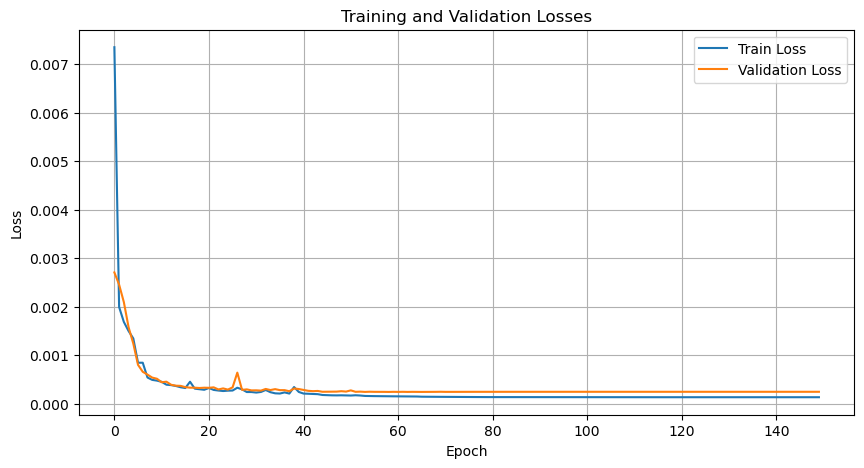

In [6]:

# Training setup
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

# Training parameters
n_epochs = 150
best_val_loss = float('inf')
train_losses = []
val_losses = []

# Training loop
print("Starting training...")
for epoch in range(n_epochs):
    print(f'\nEpoch [{epoch+1}/{n_epochs}]')
    
    # Train
    train_loss = train_epoch(model, data['train_loader'], criterion, optimizer, device)
    train_losses.append(train_loss)
    
    # Validate
    val_loss = validate(model, data['val_loader'], criterion, device)
    val_losses.append(val_loss)
    
    # Scheduler step
    scheduler.step(val_loss)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, 'best_unet_model.pth')
    
    # Print epoch results
    print(f'\nEpoch [{epoch+1}/{n_epochs}]')
    print(f'Train Loss: {train_loss:.6f}')
    print(f'Val Loss: {val_loss:.6f}')
    print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')

# Plot training results
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
def reconstruct_and_compare(model, test_loader, device):
    """Reconstruct full images using 32x32 patches with proper boundary handling"""
    model.eval()
    
    # Get a batch
    batch = next(iter(test_loader))
    
    # Get original image name and load full images
    img_file = batch['image_file'][0]
    
    # Load full input image (Bayer)
    input_path = os.path.join(data['test_dataset'].input_dir, img_file)
    input_img = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)
    bayer_img = input_img.astype(np.float32) / 65535.0
    
    # Load full ground truth image
    gt_path = os.path.join(data['test_dataset'].groundtruth_dir, img_file)
    gt_img = cv2.imread(gt_path)
    gt_img = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)
    gt_img = gt_img.astype(np.float32) / 255.0
    
    # Create bilinear interpolation
    bayer_uint8 = (bayer_img * 255).astype(np.uint8)
    bilinear = cv2.cvtColor(bayer_uint8, cv2.COLOR_BAYER_BG2RGB_EA)
    bilinear = bilinear.astype(np.float32) / 255.0
    
    # Process full image with UNet
    patch_size = 32
    overlap = 8
    h, w = bayer_img.shape
    output_img = np.zeros((h, w, 3), dtype=np.float32)
    count = np.zeros((h, w, 3), dtype=np.float32)
    
    print(f"Processing full image: {img_file}")
    print(f"Image size: {h}x{w}")
    
    with torch.no_grad():
        # Make sure to cover the entire image width
        for i in range(0, h, patch_size - overlap):
            for j in range(0, w, patch_size - overlap):
                # Handle boundary cases
                i_end = min(i + patch_size, h)
                j_end = min(j + patch_size, w)
                i_start = max(0, i_end - patch_size)
                j_start = max(0, j_end - patch_size)
                
                # Extract patch
                patch = bayer_img[i_start:i_end, j_start:j_end]
                
                # Pad if necessary
                if patch.shape[0] < patch_size or patch.shape[1] < patch_size:
                    padded_patch = np.zeros((patch_size, patch_size), dtype=patch.dtype)
                    padded_patch[:patch.shape[0], :patch.shape[1]] = patch
                    patch = padded_patch
                
                # Convert to tensor
                patch_tensor = torch.from_numpy(patch).float().unsqueeze(0).unsqueeze(0)
                patch_tensor = patch_tensor.to(device)
                
                # Process patch
                output_patch = model(patch_tensor)
                output_patch = output_patch.squeeze().cpu().numpy()
                output_patch = np.transpose(output_patch, (1, 2, 0))
                
                # If we padded, only take the valid region
                if i_end - i_start < patch_size or j_end - j_start < patch_size:
                    output_patch = output_patch[:i_end-i_start, :j_end-j_start]
                
                # Add to output image with soft blending
                output_img[i_start:i_end, j_start:j_end] += output_patch
                count[i_start:i_end, j_start:j_end] += 1
    
    # Average overlapping regions
    output_img = np.divide(output_img, count, where=count!=0)
    
    print(f"Reconstruction complete. Output shape: {output_img.shape}")
    print(f"Valid pixels: {np.sum(count > 0)}/{h*w*3}")
    
    def calculate_cpsnr(img1, img2):
        """Calculate color PSNR (average of per-channel PSNR)"""
        assert img1.shape == img2.shape
        psnr_channels = []
        
        for c in range(3):  # For each color channel
            mse = np.mean((img1[..., c] - img2[..., c]) ** 2)
            if mse == 0:
                psnr_channels.append(float('inf'))
            else:
                psnr_channels.append(20 * np.log10(1.0 / np.sqrt(mse)))
        
        return np.mean(psnr_channels), psnr_channels
    
    def calculate_ssim(img1, img2):
        """Simplified SSIM calculation"""
        c1 = (0.01 * 1) ** 2
        c2 = (0.03 * 1) ** 2
        
        img1 = img1.transpose(2, 0, 1)  # Convert to CxHxW
        img2 = img2.transpose(2, 0, 1)
        
        mu1 = img1.mean(axis=(1, 2), keepdims=True)
        mu2 = img2.mean(axis=(1, 2), keepdims=True)
        
        sigma1 = np.std(img1, axis=(1, 2), keepdims=True)
        sigma2 = np.std(img2, axis=(1, 2), keepdims=True)
        sigma12 = np.mean((img1 - mu1) * (img2 - mu2), axis=(1, 2), keepdims=True)
        
        ssim = ((2 * mu1 * mu2 + c1) * (2 * sigma12 + c2)) / \
               ((mu1**2 + mu2**2 + c1) * (sigma1**2 + sigma2**2 + c2))
        
        return ssim.mean()
    
    # Calculate metrics
    bilinear_cpsnr, bilinear_channel_psnr = calculate_cpsnr(gt_img, bilinear)
    network_cpsnr, network_channel_psnr = calculate_cpsnr(gt_img, output_img)
    
    bilinear_ssim = calculate_ssim(gt_img, bilinear)
    network_ssim = calculate_ssim(gt_img, output_img)
    
    # Visualize results
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    
    # Bayer pattern
    axes[0, 0].imshow(bayer_img, cmap='gray')
    axes[0, 0].set_title('Bayer Pattern, grayscaled')
    axes[0, 0].axis('off')
    
    # Bilinear demosaicing
    axes[0, 1].imshow(bayer_img)
    axes[0, 1].set_title('Bayer Pattern')
    axes[0, 1].axis('off')
    
    # Ground truth
    axes[1, 0].imshow(gt_img)
    axes[1, 0].set_title('Ground Truth')
    axes[1, 0].axis('off')
    
    # Our network output
    axes[1, 1].imshow(np.clip(output_img, 0, 1))
    axes[1, 1].set_title(f'UNet Output\ncPSNR: {network_cpsnr:.2f} dB\nSSIM: {network_ssim:.4f}')
    axes[1, 1].axis('off')
    
    plt.suptitle(f'Demosaicing Results - {img_file}', y=0.95, fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Print detailed quantitative results
    print("\nQuantitative Results:")
    print("\nBilinear Interpolation:")
    print(f"cPSNR: {bilinear_cpsnr:.2f} dB")
    print(f"Channel PSNRs - R: {bilinear_channel_psnr[0]:.2f}, G: {bilinear_channel_psnr[1]:.2f}, B: {bilinear_channel_psnr[2]:.2f}")
    print(f"SSIM: {bilinear_ssim:.4f}")
    
    print("\nUNet Results:")
    print(f"cPSNR: {network_cpsnr:.2f} dB")
    print(f"Channel PSNRs - R: {network_channel_psnr[0]:.2f}, G: {network_channel_psnr[1]:.2f}, B: {network_channel_psnr[2]:.2f}")
    print(f"SSIM: {network_ssim:.4f}")
    
    print("\nImprovements:")
    print(f"cPSNR Improvement: {network_cpsnr - bilinear_cpsnr:.2f} dB")
    print(f"SSIM Improvement: {network_ssim - bilinear_ssim:.4f}")
    
    return {
        'bilinear_cpsnr': bilinear_cpsnr,
        'network_cpsnr': network_cpsnr,
        'bilinear_channel_psnr': bilinear_channel_psnr,
        'network_channel_psnr': network_channel_psnr,
        'bilinear_ssim': bilinear_ssim,
        'network_ssim': network_ssim
    }



/tmp/ipykernel_1782284/3242960249.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_unet_model.pth')


Loaded model from epoch 58 with validation loss 0.000246
Processing full image: 100.png
Image size: 132x220
Reconstruction complete. Output shape: (132, 220, 3)
Valid pixels: 87120/87120


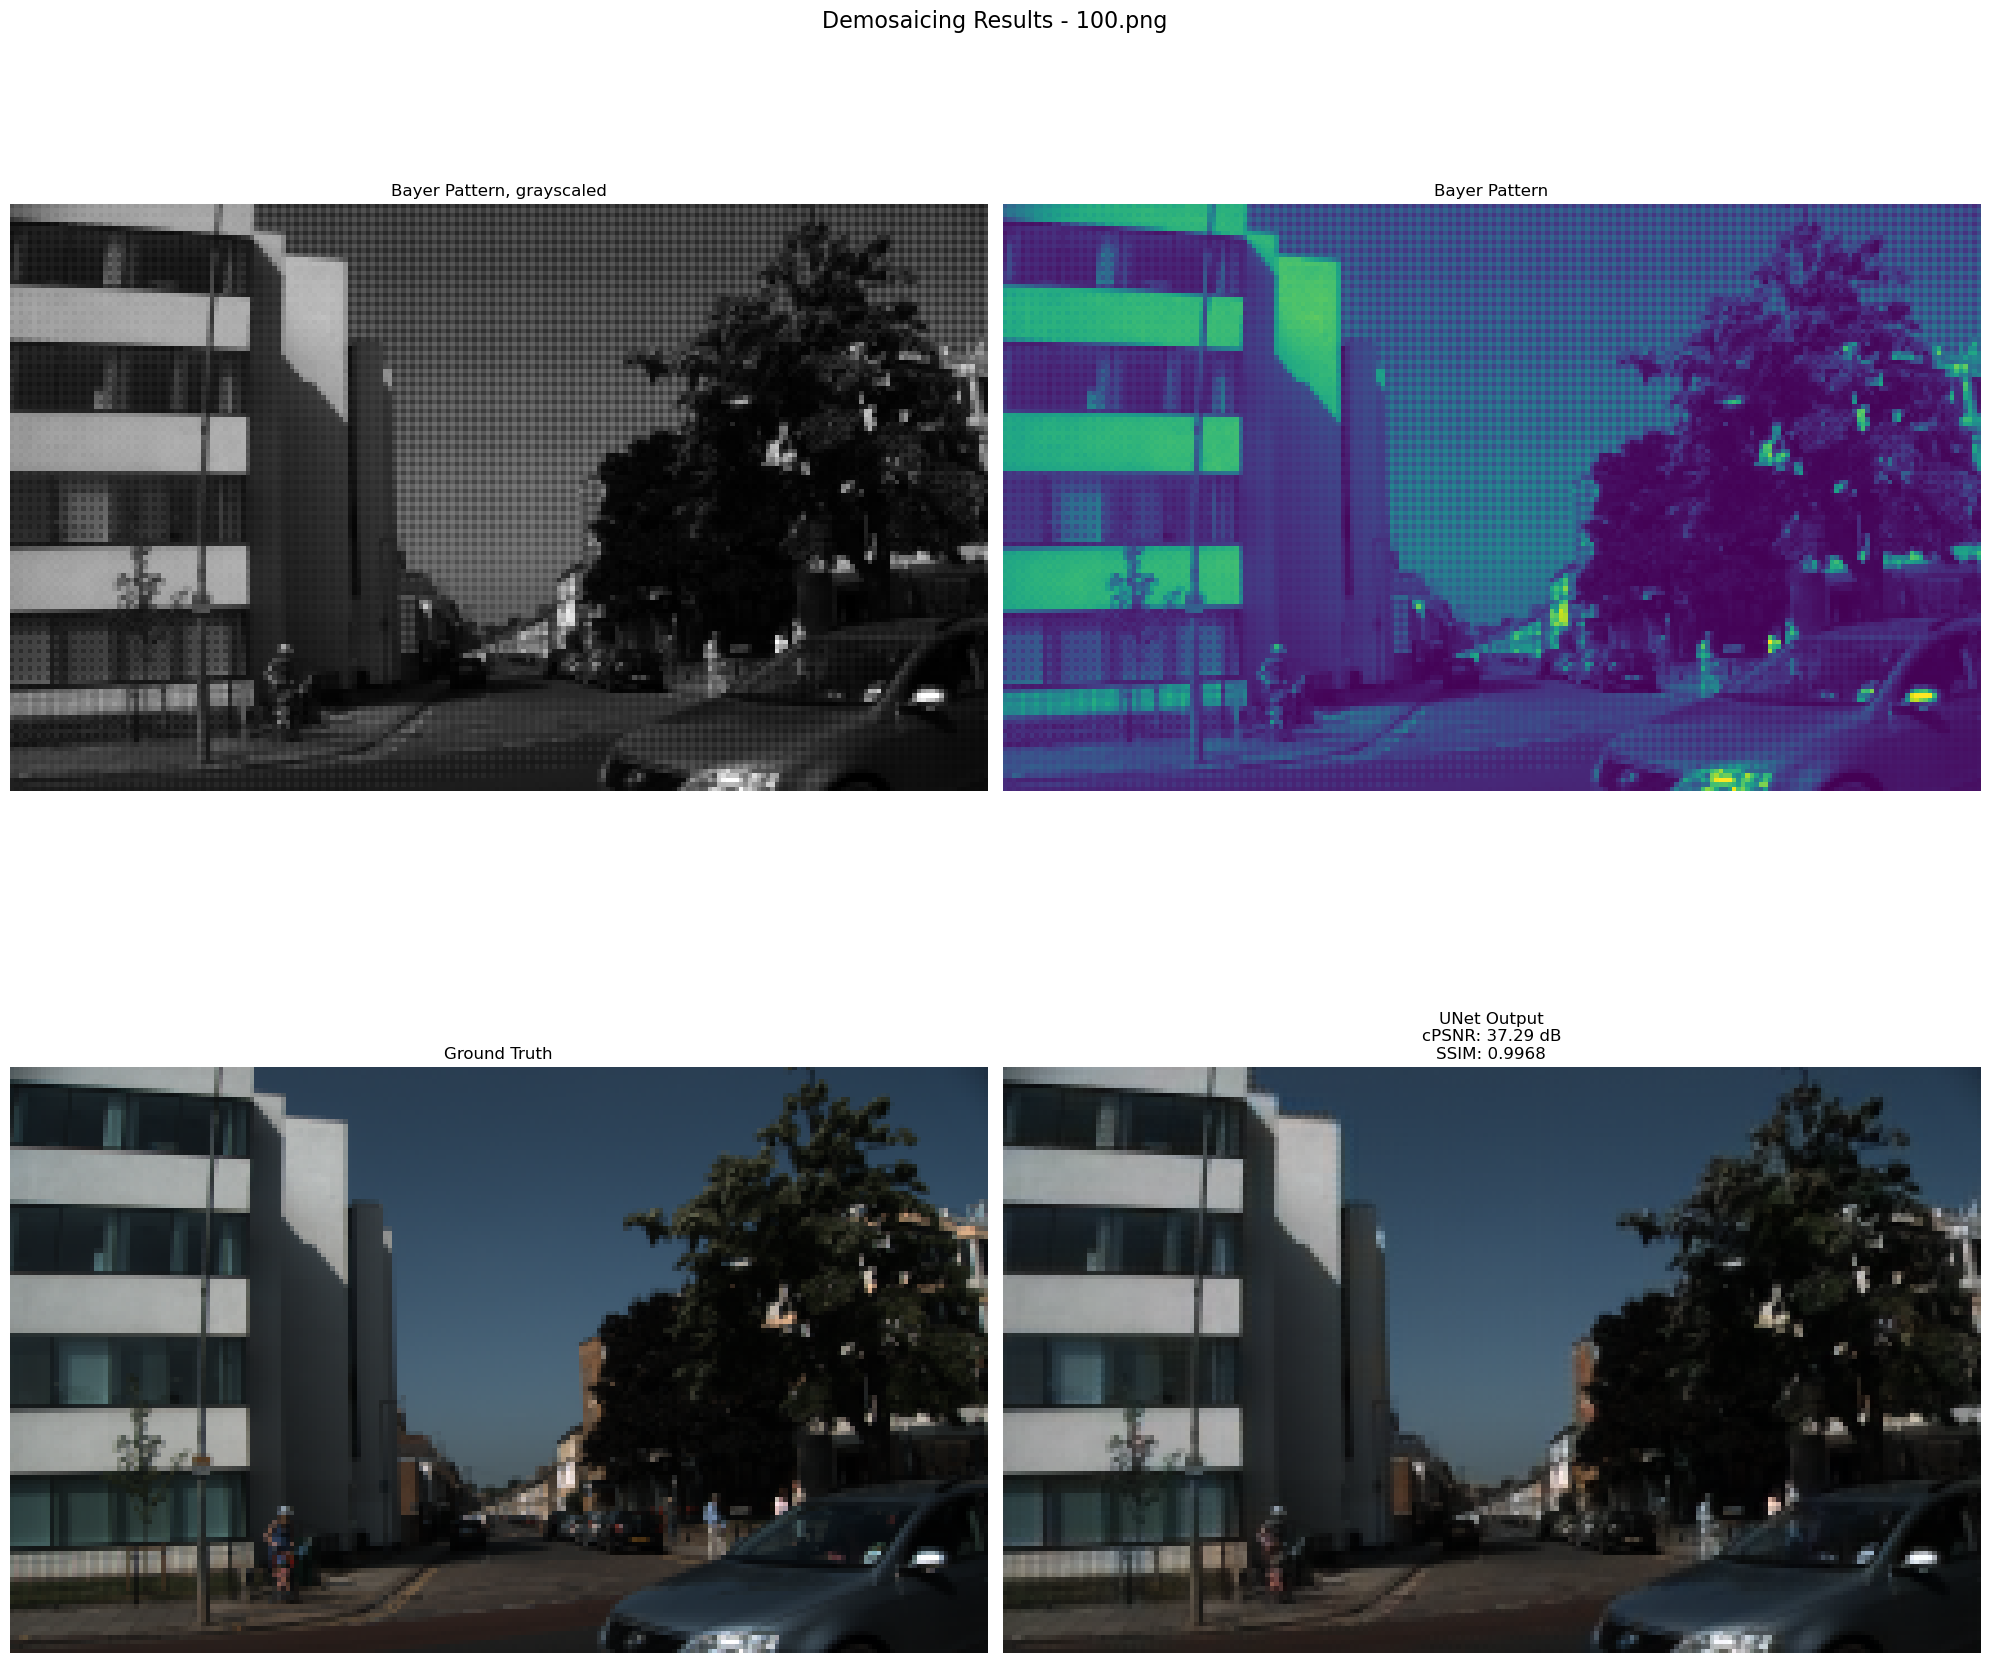


Quantitative Results:

Bilinear Interpolation:
cPSNR: 28.63 dB
Channel PSNRs - R: 26.59, G: 32.16, B: 27.14
SSIM: 0.9743

UNet Results:
cPSNR: 37.29 dB
Channel PSNRs - R: 35.87, G: 40.04, B: 35.97
SSIM: 0.9968

Improvements:
cPSNR Improvement: 8.66 dB
SSIM Improvement: 0.0225


In [8]:
# Eighth cell - Load Best Model and Evaluate

# Load best model
checkpoint = torch.load('best_unet_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded model from epoch {checkpoint['epoch']} with validation loss {checkpoint['val_loss']:.6f}")

# Test the reconstruction
metrics = reconstruct_and_compare(model, data['test_loader'], device)

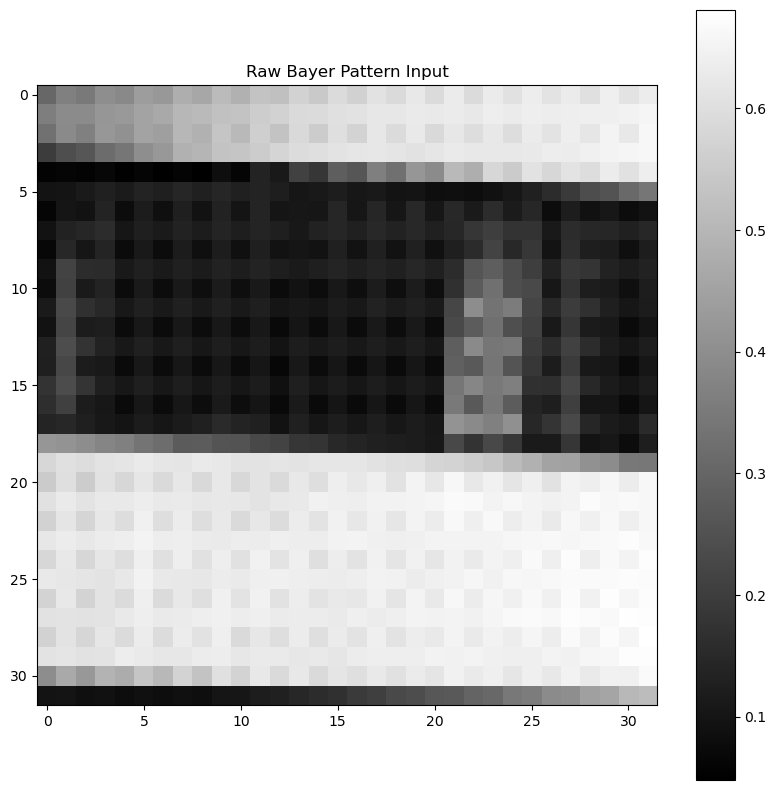

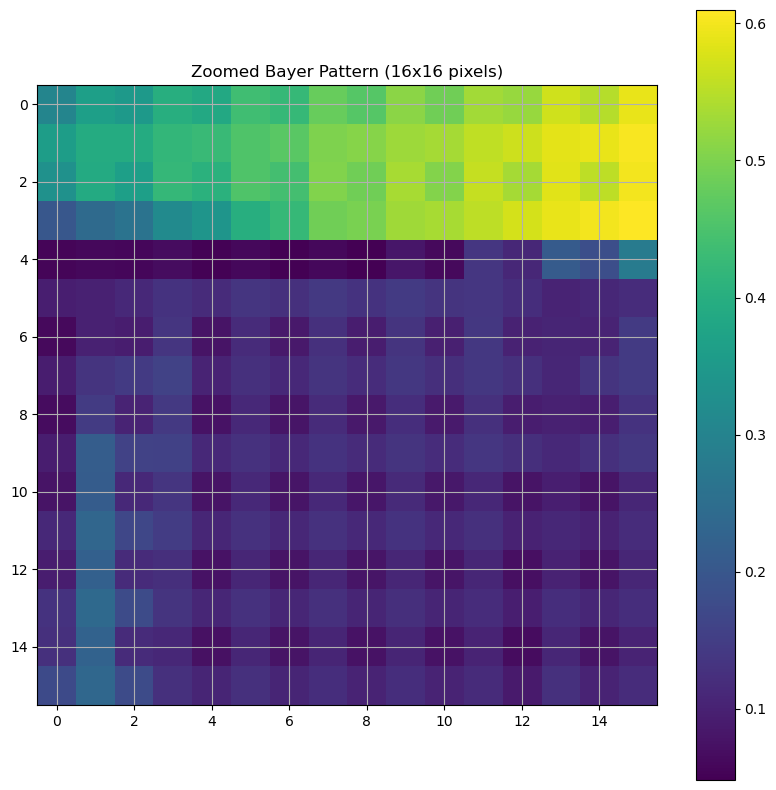

In [9]:
# Get a single batch from the test loader
batch = next(iter(data['test_loader']))
input_image = batch['input'][0].squeeze().cpu().numpy()

plt.figure(figsize=(10, 10))
plt.imshow(input_image, cmap='gray')
plt.title('Raw Bayer Pattern Input')
plt.colorbar()
plt.show()

# To see the pattern more closely, you can zoom into a small region
plt.figure(figsize=(10, 10))
plt.imshow(input_image[0:16, 0:16])
plt.title('Zoomed Bayer Pattern (16x16 pixels)')
plt.colorbar()
plt.grid(True)
plt.show()